# Урок 4
Эта демонстрация разбита на 3 ноутбука:

1. Свертки и пулинги.
2. Даталоадеры.
3. **Задача классификации с использованием CNN.**

В этой части мы решим задачу предсказания пола человека по фото.

Метрикой качества будет _accuracy_, датасет возьмем IMDB-Wiki.
В качестве бейзлайна возьмем FC-сеть, затем улучшим его с помощью сверток.
После этого мы возьмем ResNet, зафайнтюним его под нашу задачу и посмотрим на качество.

Мы увидим, что сверточные сети действительно улучшают точность предсказания. Также мы посмотрим на fine-tuning: как быстро он обучится и какое качество даст.

In [1]:
# Если работаете в colab, запустите команды ниже.
# Они скачают и распакуют датасет.
# Должна получиться папка imdb_crop.tar

!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
!tar xf imdb_crop.tar

--2026-02-20 18:37:10--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar       100%[===================>]   6.53G  22.4MB/s    in 5m 10s  

2026-02-20 18:42:21 (21.6 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]



In [2]:
import numpy as np
import cv2
import torch
from albumentations.pytorch import ToTensorV2
import albumentations as A
from scipy.io import loadmat
from torch.utils.data import Dataset


class ImdbWikiDataset(Dataset):
    def __init__(self, image_size: int = 128):
        # Из кодов выше
        imdb_dat = loadmat("imdb_crop/imdb.mat")["imdb"][0][0]
        imdb_paths = [f"imdb_crop/{path[0]}" for path in imdb_dat[2][0]]
        imdb_genders = imdb_dat[3][0]
        bad_indices = set(np.where(np.isnan(imdb_genders))[0])
        imdb_paths = [x for i, x in enumerate(imdb_paths) if i not in bad_indices]
        imdb_genders = [
            int(x) for i, x in enumerate(imdb_genders) if i not in bad_indices
        ]

        # Не будем читать картинки при создании датасета, чтобы сберечь ОЗУ.
        self.paths = imdb_paths
        self.labels = imdb_genders
        self.transforms = A.Compose(
            [
                # Подгонит под размер (128, 128)
                A.Resize(image_size, image_size),
                # A.HorizontalFlip(p=0.5),
                # Пиксели в отрезке [0; 255] - это uint8.
                # Переведем в отрезок [0.0; 1.0] - нейросети будет проще.
                A.ToFloat(max_value=255),
                # Поменяет (H, W, C) -> (C, H, W) и превратит в тензор PyTorch
                ToTensorV2(),
                # Для обогащения: будем переворачивать
            ]
        )
        assert len(self.paths) == len(self.labels)

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        # Читать будем только одну картинку - и возвращать пару (тензор картинки, ее label)
        img_numpy = cv2.imread(self.paths[index])
        img_tensor = self.transforms(image=img_numpy)["image"]

        label = self.labels[index]
        return img_tensor, label

    def __len__(self):
        return len(self.paths)

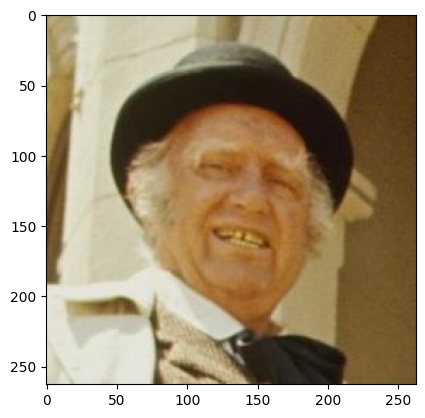

In [15]:
# Вариант 1 - использовать matplotlib
# С ним уже виделись ранее, когда работали с NotMNIST
import matplotlib.pyplot as plt
from scipy.io import loadmat

imdb_dat = loadmat("imdb_crop/imdb.mat")["imdb"][0][0]
imdb_paths = [f"imdb_crop/{path[0]}" for path in imdb_dat[2][0]]
imdb_genders = imdb_dat[3][0]

image = plt.imread(imdb_paths[1])
plt.imshow(image)
# print(image.shape)
# print(image, type(image))

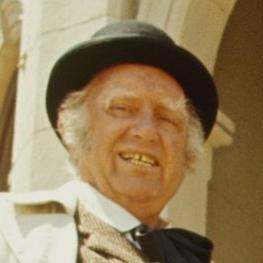

<class 'numpy.ndarray'>


In [14]:
# Вариант 3 - cv2 (a.k.a. opencv-python)
import cv2
from google.colab.patches import cv2_imshow

cv_image = cv2.imread(imdb_paths[1])
cv2_imshow(cv_image)
print(type(cv_image))
# print(cv_image.shape)
# print(cv_image)

## Классификация с использованием сверток

Попробуем решить задачу классификации пола на таком большом датасете.
Какие модели будем использовать:
- FC (_бейзлайн_);
- одна свертка и нелинейность;
- три свертки;
- три свертки и batch normalization;
- три свертки, batch normalization, dropout; 

Оптимизировать будем бинарную кросс-энтропию (BCE), в качестве метрики качества выберем accuracy.

In [16]:
import random
import os
from dataclasses import dataclass


@dataclass
class Config:
    seed: int = 0

    # Данные
    batch_size: int = 64
    do_shuffle_train: bool = True
    img_size: int = 128
    ratio_train_val_test: tuple[float, float, float] = (0.8, 0.1, 0.1)

    # Модель
    hidden_dim: int = 512
    p_dropout: float = 0.3

    # Обучение
    n_epochs: int = 10
    eval_every: int = 2000
    lr: float = 1e-5


def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)


def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)


config = Config()
enable_determinism()
fix_seeds(config.seed)

In [17]:
from torch.utils.data import DataLoader, random_split

# Готовим заново датасеты
generator = torch.Generator()
generator.manual_seed(config.seed)

dataset = ImdbWikiDataset(image_size=config.img_size)
train_dataset, val_dataset, test_dataset = random_split(
    dataset, lengths=config.ratio_train_val_test, generator=generator
)


# https://pytorch.org/docs/stable/notes/randomness.html#dataloader
def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=config.do_shuffle_train,
    generator=generator,
    drop_last=True,
    # Для скорости будем готовить данные в 4 процессах
    num_workers=2,
    pin_memory=True,
    # Это для воспроизводимости https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    worker_init_fn=seed_worker,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True,
)
# Здесь не будем использовать test_loader и test_dataset. Но обычно работают так:
# - на train данных обучают модель;
# - на val данных подбирают гиперпараметры;
# - на test данных финально оценивают качество модели (после подбора гиперпараметров).

In [18]:
import torch.nn as nn


class FcModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.img_size = config.img_size
        self.hidden_dim = config.hidden_dim
        n_channels = 3
        self.fc = nn.Sequential(
            nn.Linear(self.img_size * self.img_size * n_channels, self.hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_dim),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_dim // 2),
            nn.Linear(self.hidden_dim // 2, self.hidden_dim // 4),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_dim // 4),
            nn.Linear(self.hidden_dim // 4, 1),
            # Будем предсказывать логиты вероятностей
        )

    def forward(self, x):
        # Схлопнем (N, C, H, W) -> (N, C * H * W)
        x = x.reshape((x.shape[0], -1))
        # И прогоним через линейные слои
        return self.fc(x)


model = FcModel(config)
x, y = next(iter(train_loader))
print(x.shape)
print(model(x).shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1])


In [19]:
# Пойдем учиться.
# В качестве ошибки возьмем BCE
import torch.nn.functional as F
import tqdm
import wandb
from torch.optim import Adam


def calc_accuracy(model: nn.Module, loader: DataLoader, device: torch.device):
    count_correct, count_total = 0, 0
    model.eval()
    for img_batch, true_labels in loader:
        img_batch = img_batch.to(device)
        true_labels = true_labels.to(device)
        with torch.no_grad():
            pred_val = model(img_batch).squeeze()
        # Будем предсказывать самый вероятный класс (т.е. порог 0.5 вероятности).
        # Тогда p > 0.5 будет на положительных логитах, а p < 0.5 - на отрицательных
        pred_labels = pred_val >= 0
        count_correct += (pred_labels == true_labels).sum().item()
        count_total += len(true_labels)
    model.train()
    return count_correct / count_total


def train_loop(
    config: Config,
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    params_subset: list | None = None,
):
    if params_subset is None:
        params_subset = model.parameters()
    optimizer = Adam(params_subset, lr=config.lr)
    model.to(device)

    for epoch in range(config.n_epochs):
        print(f"Epoch #{epoch + 1}/#{config.n_epochs}")
        for i, (img_batch, true_labels) in enumerate(tqdm.tqdm(train_loader)):
            step = epoch * len(train_loader) + i
            img_batch, true_labels = img_batch.to(device), true_labels.to(device)

            optimizer.zero_grad()
            pred_labels = model(img_batch).squeeze()
            loss = F.binary_cross_entropy_with_logits(pred_labels, true_labels.float())
            loss.backward()
            optimizer.step()

            wandb.log({"loss": loss.cpu().item()}, step=step)
            if (i + 1) % config.eval_every == 0:
                # Подсчитаем accuracy на всем валидационном датасете
                wandb.log(
                    {"accuracy": calc_accuracy(model, val_loader, device)}, step=step
                )
        # В конце эпохи тоже напечатаем accuracy на val-датасете
        wandb.log({"accuracy": calc_accuracy(model, val_loader, device)}, step=step)

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Apple Silicon
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("using device", device)

using device cuda


In [21]:
wandb.init(project="lesson-4", name="simple-fc", config=config.__dict__)
# train_loop(config, model, train_loader, val_loader=val_loader, device=device)
wandb.finish()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: a-s-kurdyubov (a-s-kurdyubov-spbu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Accuracy 69% - негусто. А какое качество дало бы константное предсказание?

In [23]:
from collections import Counter

c = Counter(dataset.labels)

c[1] / (c[1] + c[0])

0.5819957944638162

Бейзлайн лучше, чем константное предсказние, но несильно.

Давайте попробуем улучшить accuracy через сверточные сети.

In [9]:
class CnnModelBase(nn.Module):
    def build_model(self):
        raise NotImplementedError()

    def explain_output(self, x: torch.Tensor):
        # Печатает размеры тензора на выходе каждого слоя
        print("## Модель ##")
        print(model)
        print("## Размерности")
        print("Пришел x:", x.shape)
        current = x
        for one_layer in self.net:
            print("#######")
            print("Слой:".ljust(8), one_layer)
            print("До:".ljust(8), current.shape)
            current = one_layer(current)
            print("После:".ljust(8), current.shape)
        print("## После всей модели")
        print(self(x).shape)

    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        # Нам хватит поменьше размерности внутри
        self.hidden_dim = 64
        self.n_channels = 3
        self.net = self.build_model()
        self.head = nn.Linear(in_features=self.hidden_dim, out_features=1)

    def forward(self, x):
        x = self.net(x).squeeze()
        x = self.head(x).squeeze()
        return x

In [10]:
class SimpleCnn(CnnModelBase):
    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels, out_channels=self.hidden_dim, kernel_size=3
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=self.config.img_size - 3 + 1),
        )


model = SimpleCnn(config)
x, y = next(iter(train_loader))
model.explain_output(x)

## Модель ##
SimpleCnn(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=126, stride=126, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Linear(in_features=64, out_features=1, bias=True)
)
## Размерности
Пришел x: torch.Size([64, 3, 128, 128])
#######
Слой:    Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
До:      torch.Size([64, 3, 128, 128])
После:   torch.Size([64, 64, 126, 126])
#######
Слой:    ReLU()
До:      torch.Size([64, 64, 126, 126])
После:   torch.Size([64, 64, 126, 126])
#######
Слой:    MaxPool2d(kernel_size=126, stride=126, padding=0, dilation=1, ceil_mode=False)
До:      torch.Size([64, 64, 126, 126])
После:   torch.Size([64, 64, 1, 1])
## После всей модели
torch.Size([64])


In [11]:
wandb.init(project="lesson-4", name="1-conv", config=config.__dict__)
train_loop(config, model, train_loader, val_loader, device=device)
wandb.finish()

Epoch #1/#10


100%|██████████| 5653/5653 [01:15<00:00, 75.34it/s]


Epoch #2/#10


100%|██████████| 5653/5653 [01:16<00:00, 74.10it/s]


Epoch #3/#10


100%|██████████| 5653/5653 [01:28<00:00, 64.07it/s]


Epoch #4/#10


100%|██████████| 5653/5653 [01:17<00:00, 72.84it/s]


Epoch #5/#10


100%|██████████| 5653/5653 [01:17<00:00, 73.03it/s]


Epoch #6/#10


100%|██████████| 5653/5653 [01:17<00:00, 73.11it/s]


Epoch #7/#10


100%|██████████| 5653/5653 [01:17<00:00, 73.16it/s]


Epoch #8/#10


100%|██████████| 5653/5653 [01:17<00:00, 72.93it/s]


Epoch #9/#10


100%|██████████| 5653/5653 [01:19<00:00, 71.49it/s]


Epoch #10/#10


100%|██████████| 5653/5653 [01:19<00:00, 70.93it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▁▁▁▁▁▁▂▃▃▄▄▅▅▅▆▅▆▆▆▇▇▇▇▇▇█▇█
loss,▅▃█▄▄▆▆▃▃▃▆▆▃▇▇▇▃▅▁▂▃▃▂▇▅▅▃▅▂▃▇▂▄▅▅▇▁▅▃▂
accuracy,0.60362
loss,0.69454


In [12]:
class Cnn3Layers(CnnModelBase):
    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=28),
        )


model = Cnn3Layers(config)
x, _ = next(iter(train_loader))
model.explain_output(x)

## Модель ##
Cnn3Layers(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=28, stride=28, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Linear(in_features=64, out_features=1, bias=True)
)
## Размерности
Пришел x: torch.Size([64, 3, 128, 128])
#######
Слой:    Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
До:      torch.Size([64, 3, 128, 128])
После:   torch.Size([64, 64, 126, 126])
#######
Слой:    ReLU()
До:      torch.Size([64, 64, 126, 126])
После:   torch.Size([64, 64, 126, 126])
#######
Слой:    MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
До:      torch

In [13]:
wandb.init(project="lesson-4", name="3-conv", config=config.__dict__)
train_loop(config, model, train_loader, val_loader, device=device)
wandb.finish()

Epoch #1/#10


 35%|███▌      | 1992/5653 [00:28<00:52, 70.36it/s]

100%|██████████| 5653/5653 [01:48<00:00, 52.08it/s]


Epoch #2/#10


100%|██████████| 5653/5653 [02:04<00:00, 45.43it/s]


Epoch #3/#10


100%|██████████| 5653/5653 [02:25<00:00, 38.84it/s]


Epoch #4/#10


100%|██████████| 5653/5653 [02:02<00:00, 46.12it/s]


Epoch #5/#10


100%|██████████| 5653/5653 [02:31<00:00, 37.35it/s]


Epoch #6/#10


100%|██████████| 5653/5653 [02:13<00:00, 42.35it/s]


Epoch #7/#10


100%|██████████| 5653/5653 [02:04<00:00, 45.48it/s]


Epoch #8/#10


100%|██████████| 5653/5653 [02:23<00:00, 39.48it/s]


Epoch #9/#10


100%|██████████| 5653/5653 [02:17<00:00, 40.99it/s]


Epoch #10/#10


100%|██████████| 5653/5653 [02:00<00:00, 46.84it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
loss,▅▆▅▅▅▅▄▄▄▅▅▅▆▆▆▅▄▆▃▃▄▆▅▅▆▅▄▃▂▄▅▄▅▅▃▁▄▃▄█
accuracy,0.66572
loss,0.60438


In [14]:
class Cnn3LayersBn(CnnModelBase):
    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            # >>>>>
            nn.BatchNorm2d(self.hidden_dim),
            # <<<<<
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            # >>>>>
            nn.BatchNorm2d(self.hidden_dim),
            # <<<<<
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            # >>>>>
            nn.BatchNorm2d(self.hidden_dim),
            # <<<<<
            nn.MaxPool2d(kernel_size=28),
        )


model = Cnn3LayersBn(config)
x, _ = next(iter(train_loader))
model.explain_output(x)

## Модель ##
Cnn3LayersBn(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=28, stride=28, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Linear(in_features=64, out_features=1, bias=True)
)
## Размерности
Пришел x: torch.Size([64, 3, 128, 128])
#######
Слой:    Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
До:      torch.Siz

In [15]:
wandb.init(project="lesson-4", name="3-conv-bn", config=config.__dict__)
train_loop(config, model, train_loader, val_loader, device=device)
wandb.finish()

Epoch #1/#10


100%|██████████| 5653/5653 [02:40<00:00, 35.26it/s]


Epoch #2/#10


100%|██████████| 5653/5653 [02:38<00:00, 35.56it/s]


Epoch #3/#10


100%|██████████| 5653/5653 [03:02<00:00, 31.01it/s]


Epoch #4/#10


100%|██████████| 5653/5653 [03:04<00:00, 30.57it/s]


Epoch #5/#10


100%|██████████| 5653/5653 [02:44<00:00, 34.26it/s]


Epoch #6/#10


100%|██████████| 5653/5653 [02:37<00:00, 35.88it/s]


Epoch #7/#10


100%|██████████| 5653/5653 [02:46<00:00, 33.97it/s]


Epoch #8/#10


100%|██████████| 5653/5653 [02:48<00:00, 33.60it/s]


Epoch #9/#10


100%|██████████| 5653/5653 [03:03<00:00, 30.73it/s]


Epoch #10/#10


100%|██████████| 5653/5653 [02:32<00:00, 37.10it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█████████████
loss,█▇▇▆▆▆▅▅▅▄▆▃▄▆▂▆▄▄▄▁▂▅▅▅▃▄▂▄▃▄▂▆▆▄▄▄▅▂▃▄
accuracy,0.73621
loss,0.55916


In [16]:
class Cnn3LayersBnDropout(CnnModelBase):
    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            nn.BatchNorm2d(self.hidden_dim),
            # >>>>>
            nn.Dropout(p=self.config.p_dropout),
            # <<<<<
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            nn.BatchNorm2d(self.hidden_dim),
            # >>>>>
            nn.Dropout(p=self.config.p_dropout),
            # <<<<<
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=self.hidden_dim, kernel_size=3, out_channels=self.hidden_dim
            ),
            nn.ReLU(),
            nn.BatchNorm2d(self.hidden_dim),
            # >>>>>
            nn.Dropout(p=self.config.p_dropout),
            # <<<<<
            nn.MaxPool2d(kernel_size=28),
        )


model = Cnn3LayersBn(config)
x, _ = next(iter(train_loader))
model.explain_output(x)

## Модель ##
Cnn3LayersBn(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=28, stride=28, padding=0, dilation=1, ceil_mode=False)
  )
  (head): Linear(in_features=64, out_features=1, bias=True)
)
## Размерности
Пришел x: torch.Size([64, 3, 128, 128])
#######
Слой:    Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
До:      torch.Siz

In [17]:
wandb.init(project="lesson-4", name="3-conv-bn-dropout", config=config.__dict__)
train_loop(config, model, train_loader, val_loader, device=device)
wandb.finish()

Epoch #1/#10


  9%|▉         | 535/5653 [00:13<02:04, 41.21it/s]

100%|██████████| 5653/5653 [02:33<00:00, 36.92it/s]


Epoch #2/#10


100%|██████████| 5653/5653 [02:32<00:00, 37.10it/s]


Epoch #3/#10


100%|██████████| 5653/5653 [02:41<00:00, 35.11it/s]


Epoch #4/#10


100%|██████████| 5653/5653 [02:58<00:00, 31.71it/s]


Epoch #5/#10


100%|██████████| 5653/5653 [02:44<00:00, 34.29it/s]


Epoch #6/#10


100%|██████████| 5653/5653 [02:26<00:00, 38.67it/s]


Epoch #7/#10


100%|██████████| 5653/5653 [02:04<00:00, 45.56it/s]


Epoch #8/#10


100%|██████████| 5653/5653 [02:04<00:00, 45.56it/s]


Epoch #9/#10


100%|██████████| 5653/5653 [02:04<00:00, 45.28it/s]


Epoch #10/#10


100%|██████████| 5653/5653 [02:25<00:00, 38.74it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▄▅▆▆▆▆▇▇▇▇█▇▇██████████████
loss,█▇▆█▅▆▅▆▄▆▄▅▄▂▆▂█▅▆▄▃▇▄▅▂▄▅▆▃▄▁▅▃▆▄▃▇▄▄▅
accuracy,0.73453
loss,0.53836


**Вывод**: сверточные сети действительно помогли выбить большее качество.

## Fine-tuning готовой модели
Возьмем обученный ResNet и попробуем адаптировать его мощь под нашу задачу.

In [24]:
from torchvision.models import resnet34


def make_resnet():
    """Сделать модель resnet для fine-tuning.

    1. Скачивает готовый обученный ResNet.
    2. Заменяет последний слой в нем на Linear(..., 1).
    3. Инициализирует веса этому слою.
    """
    fix_seeds(config.seed)
    base_model = resnet34()
    base_model.fc = nn.Linear(base_model.fc.in_features, 1)
    torch.nn.init.xavier_uniform_(base_model.fc.weight)
    return base_model


resnet = make_resnet()
resnet(x).shape

torch.Size([64, 1])

In [29]:
fc_params = [v for k, v in resnet.named_parameters() if k in {'fc.weight', 'fc.bias'}]
fc_params

[Parameter containing:
 tensor([[-0.0845,  0.0457,  0.0519,  0.0179,  0.0404,  0.0009, -0.0027, -0.0202,
          -0.0764, -0.0424, -0.0868,  0.0976,  0.1055, -0.0509,  0.0054, -0.0230,
          -0.0206, -0.0686,  0.0041,  0.0559, -0.0777,  0.1026,  0.1016,  0.0169,
          -0.0404, -0.0082, -0.0285,  0.0719,  0.0938, -0.0033, -0.0188,  0.0350,
           0.0180,  0.0831,  0.0243, -0.0266,  0.0221,  0.0524,  0.0378,  0.0520,
           0.0943,  0.0585,  0.0035,  0.1005, -0.0616,  0.0489,  0.0823, -0.0679,
           0.1009, -0.1020, -0.0618, -0.0304, -0.0105, -0.0531, -0.0260, -0.1033,
          -0.0702, -0.0708,  0.0913, -0.0321, -0.0213, -0.1020, -0.1029,  0.0766,
           0.0264,  0.0531, -0.0483, -0.0185, -0.0994, -0.0842,  0.0589, -0.1061,
          -0.0360,  0.0577,  0.0552,  0.0745, -0.0016,  0.0018,  0.0875,  0.0912,
          -0.0455, -0.0989, -0.0139,  0.0818, -0.0384,  0.0458,  0.0140, -0.0952,
           0.1079,  0.0582,  0.0502,  0.0109, -0.0100, -0.0301, -0.0315, -0

In [30]:
wandb.init(project="lesson-4", name="resnet-finetune", config=config.__dict__)
train_loop(
    config, resnet, train_loader, val_loader, device=device, params_subset=fc_params
)
wandb.finish()

Epoch #1/#10


100%|██████████| 5653/5653 [13:20<00:00,  7.07it/s]   


Epoch #2/#10


100%|█████████▉| 5635/5653 [13:11<00:02,  7.12it/s]   


KeyboardInterrupt: 

Вообще, мы могли зафайнтюнить не только ResNet, но и любую сеть из рассмотренных на лекции!

In [21]:
# VGG
from torchvision.models import vgg11

vgg = vgg11()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

Вы можете самостоятельно попробовать поменять ResNet на любую из изученных в лекции архитектур - и сравнить качество.

## Резюме

1. Научились работать с датасетами/даталоадерами.
2. Посмотрели на качество FC и CNN в классификации картинок - увидели, что CNN выбивает большее качество.
3. Попробовали сделать fine-tuning ResNet под нашу задачу.